### Diffusion notes - 02/18/24

A mildly interesting description of diffusion models given by GPT-4:

In the context of machine learning, diffusion models refer to a class of probabilistic models that generate new samples through a dynamic, iterative process. They start with a simple distribution, often a Gaussian, that gradually "diffuses" into a more complex one through a series of steps.

Initially introduced for unsupervised learning, diffusion models have gained popularity in generative modeling, especially for tasks like image and speech synthesis. They can iteratively refine an initial random sample into a sample that appears as if it is drawn from the data distribution.

In image generation, they represent an alternative to Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs). Diffusion models can generate distinctive images with state-of-the-art fidelity and variety, surpassing GANs in certain cases.

A significant advantage of diffusion models is their simplicity and theoretical elegance, as they involve a straightforward training process with a clearly defined objective function, unlike the often unstable adversarial training process of GANs and the approximate inference used in VAEs.

### Notes from Youtube video 'What are Diffusion Models?' 

If we added gaussian noise to the image below, it would eventually become indecipherable static. Diffusion models allow us to revert the image back to something useful or interesting.

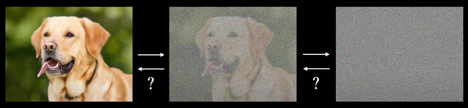

Denote an image $x_0$ and $x_T$ as the noisy static image. The map $x_0 \rightarrow x_1 \rightarrow \dots \rightarrow x_T$ is a markov chain that we can call 

$q(x_{1:T}|x_0) = \prod_{t=1}^T\limits q(x_1|x_{t-1})$

Where each step only depends on the previous state.


##### Forward

Each step is a diagonal gaussion defined as ~ $\mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1}, \beta_tI)$ where I is the indentity matrix providing the diagonal nature and $\beta$ is the variance at time t. This variance increases with time during training but is bound $\beta \in (1,0)$. as $x_T$ approaches infinity, $q(x_T|x_0) \approx \mathcal{N}(0, I)$. We use a small step size and in practice steps T is in the order of 1000

##### Backwards

Diffusion models use the observation that in the limit of infintesimal step size, the true reverse process will have the same form as the forward. This means we can also model and define the reverse step as a Unimodal, diagonal Gaussian while also using time t.

$p_\theta (x_{t-1}|x_0) := \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$

$x_0 \leftarrow \dots \leftarrow x_{T-1} \leftarrow x_T$

$p_\theta(x_{0:T}) := p(x_T) \prod_{t=1}^T\limits p_\theta(x_{t-1}|x_t)$

so we can write this reverse process markov chain (above) as a joint probability of the product of conditional probabilities and marginal probability of $x_T$

Where $p(x_T)$ is the same as q from the forward process:  ~ $\mathcal{N}(x_T;0,I)$

This means that at inference time, we start from a gaussian (static looking) image $x_T$ and make our way back to $x_1$ using our learned parameters.

##### Objective optimization

We can't directly calculate the probability of $x_0$ by $p_\theta(x_0) = \int p_\theta(x_{0:T})dx_{1:T}$ because we would have to calculate all possible paths from 0 to T which would be intractible.

but what we can do, is calculate a lower bound.

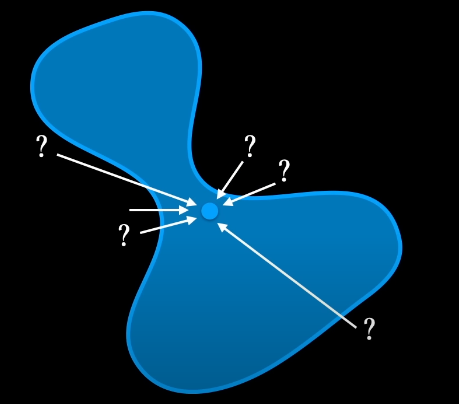

A useful trick is to view $x_0$ as an observed variable and $x_{1:T}$ as latent variable. Similarly in other transormer model/architectures, this can be seen as a latent variable generative model. These models use encoders and decoders to deal with these latent variables.

If we have observed variable x and latent variables z we can establish a variational lower bound that is less than or equal to the marginal log likeliood 

$\log p_\theta(x) \geq $ variational lower bound

where the v.l.b. := $\mathbb{E}_{q(z|x)}[\log p_\theta(x|z)] - D_{KL}(q(z|x) || p_\theta(z))$

The first term is a likelihood term which encourages the model to maximize the expected density assigned to the data

The second is a KL Divergence term which encourages the approx and posterior $q(z|x)$ to be similar to the prior on the latent variable $p_\theta(z)$

We can rewrite this using our $x_0$ observed and $x_{1:T}$ latent variables

$\log p_\theta(x_0) \geq \mathbb{E}_{q(x_{1:T}|x_0)}[\log p_\theta(x_0|x_{1:T})] - D_{KL}(q(x_{1:T}|x_0) || p_\theta(x_{1:T}))$

This KL Divergence can be expanded to include both terms in a single expectation

$$
\begin{split}
\log p_\theta(x_0) \geq \ &
      \mathbb{E}_{q(x_{1:T}|x_0)}[\log p_\theta(x_0|x_{1:T})] - D_{KL}(q(x_{1:T}|x_0) || p_\theta(x_{1:T})) \\
    \geq \space &
      \mathbb{E}_q[\log p_\theta(x_0|x_{1:T})] -  \mathbb{E}_q\Big[\log \frac{q(x_{1:T}|x_0)}{p_\theta(x_{1:T})}\Big]\\
    \geq \space &
      \mathbb{E}_q\Big[\log p_\theta(x_0|x_{1:T}) + \log \frac{p_\theta(x_{1:T})}{q(x_{1:T}|x_0)}\Big]\\
    \geq \space &
      \mathbb{E}_q\Big[ \log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)}\Big]\\
\end{split}
$$

Then we can rewrite this final result by refactoring the chain probabilities into their indiviudal steps.

$\mathbb{E}_q \Big[\log p(x_T) + \sum_{t\geq1}\limits \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})}\Big]$

A useful property of the forward pass markov chain is that any step t can be sampled directly in closed form because the sum of any sequence of gaussians is still a gaussian.

$q(x_T|x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha}_t)I)$

where $\alpha_t := 1 - \beta_t,  \bar{\alpha_t} := \prod_{s=1}^t\limits a_s$

We saw this before, but specifically for $x_0$

This means that at training time, any step t can be found without the need to derive a full chain. We can also optimize this process by sampling $x_t$ and $x_{t-1}$ and maximizing the conditional density assigned to $x_{t-1}$ by the reverse step. This is where our learned parameters come in!

However, because there can be many paths taken from $x_0$ to $x_t$ depending on the sample we are using, this means that this process can have extremely high variance. Similarly to something like ridge regression, we can sacrifice bias for a lower varaiance in this next step.

To reduce variance, we need to rearrange this object.

$\mathbb{E}_q[- D_{KL}(q(x_T|x_0) || p_\theta(x_T)) - \sum_{t>1}\limits D_{KL}(q(x_{t-1}|x_t\,x_0) || p_\theta(x_{t-1}|x_t)) + \log p_\theta(x_0|x_1)]$


where $p_\theta(x_t)$ our starting point for the reverse process and $q(x_t|x_0)$ our forward chain are both fixed. Because of this, we can concentrate on the later half of the expression

$\mathbb{E}_q[- \sum_{t>1}\limits D_{KL}(q(x_{t-1}|x_t\,x_0) || p_\theta(x_{t-1}|x_t)) + \log p_\theta(x_0|x_1)] - C$

In the sum of $D_{KL}$ KL divergences, each are between a reverse step and a forward process posterior conditioned on $x_0$. Both of these can be proved to be Gaussians and this helps to reduce variance in the training process because the targets for the reverse step become to true posteriors for the forward process, given $x_0$

##### How can we implement this reverse process?...

DDPM, Ho et. al 2020 set $\Sigma_\theta$ as fixed and task the reverse process with finding the noise added to each image in the forward process, rather than finding $\mu\theta$

$p_\theta (x_{t-1}|x_t) := \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$

Reparameterixing the forward step:  adding noise variable eplison 

$q(x_t|x_1) = \mathcal{N}(x_t; \sqrt{\bar{a_t}}x_0, (1-\bar{a_t})I) \space \rightarrow \space x_t = \sqrt{\bar{a_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon$

where $\alpha_t := 1 - \beta_t,  \bar{\alpha_t} := \prod_{s=1}^t\limits a_s$ and $\epsilon \sim \mathcal{N}(0,I)$

Therefore, we can write our loss function $\mathcal{L}$ as

$\mathcal{L} = \mathbb{E}_{x_0,\epsilon,t}\Big[\|\epsilon - \epsilon_\theta(x_t,t)\|^2\Big]$



#### Appendix 

##### what is a KL divergence?

A Kullback–Leibler divergence is a way to measure the distance between two different distributions. it is a 'statistical' distance of how different two distributions are. This distance is motivated and derived from looking at how likely distribution Q is to generate samples from the first distribution, P. This divergence is defined as the following for discrete distributions.

$D_{KL}(P\|Q) = \sum_{i}\limits P(i)\log \frac{P(i)}{Q(i)}$


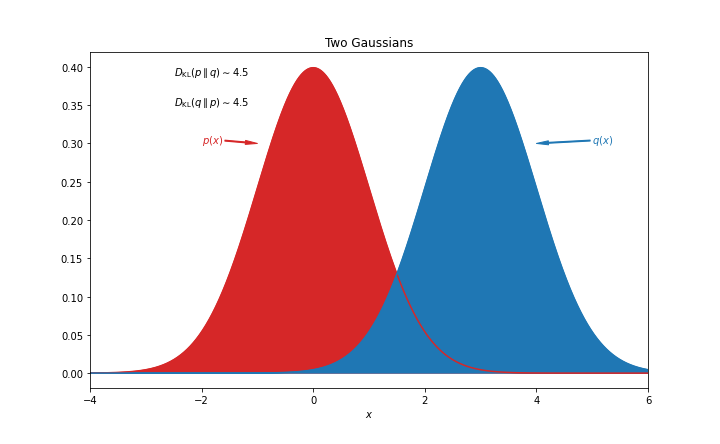

##### Markov Chains

A Markov chain or Markov process is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. We can define this as the following.

$P(X_{n+1} = x | X_1 = x_1, X_2 = x_2, \dots, X_n = x_n ) = P(X_{n+1} = x | X_n = x_n)$


Markov chains can also be written in their matrix form as show below. Each entry in the matrix represents the probability that in step n+1 the chain will transition from n to n+1. This is an extremely useful abstraction and observation about systems that occur in our natural world. Markov chains have many interesting properties and have been a foundation for many further applications and studies for the past hundred+ years. 


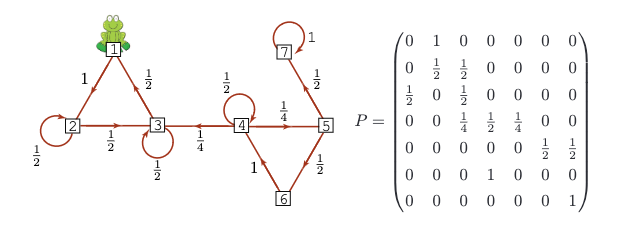

Markov Property

Theorem. Let $\lambda$ be a distribution (on space S) and P a stocastic matrix. The sequence $X = (X_0, X_1, \dots)$ is a Markov chain within initial distribution $\lambda$ and transition matrix iff:

$\mathbb{P} = (X_0 = i_o, X_1 = i_1, \dots) = \lambda_{i0}p_{i0,i1}p_{i1,i2} \dots p_{in-1, in}$

for all $n, i_0, \dots i_n$

Proof. let $A_k$ be the event $X_k = i_k$. Then we can write (*) as 

$\mathbb{P} = (A_0 \cap A_1 \cap \dots \cap A_n) = \lambda_{i0}p_{i0,i1}p_{i1,i2} \dots p_{in-1, in}$

We first assume that X is a Markov chain. We can prove (*) by induction on n. When n = 0, (∗) says $P(A_0) = \lambda_{i0}$. This is true by definition of $\lambda$.
Assume that it is true for all n < N. Then

$$
\begin{split}
\mathbb{P}(A_0 \cap A_1 \cap \dots \cap A_n) = \ & \mathbb{P}(A_0, \dots, A_{N-1})\mathbb{P}(A_0, \dots, A_{N}|A_0, \dots, A_{N-1}) \\
    = \ & \lambda_{i0}p_{i0,i1} \dots p_{iN-2, iN-1}\mathbb{P}(A_{N}|A_0, \dots, A_{N-1}) \\
    = \ & \lambda_{i0}p_{i0,i1} \dots p_{iN-2, iN-1}\mathbb{P}(A_{N}|A_{N-1}) \\
    = \ & \lambda_{i0}p_{i0,i1} \dots p_{iN-2, iN-1}p_{iN-1,iN} \\
\end{split}
$$

So it is true for N as well. Hence we are done by induction.

Conversely, suppose that (∗) holds. Then for n = 0, we have $P(X_0 = i_0) = \lambda_{i0}$.
Otherwise,

$$
\begin{split}
\mathbb{P} = (X_0 = i_o, X_1 = i_1, \dots) = \ & \mathbb{P}(A_{N}|A_0 \cap \dots \cap A_{N-1})  \\
    = \ & \frac{\mathbb{P}(A_0 \cap \dots \cap A_{N})}{\mathbb{P}(A_0 \cap \dots \cap A_{N-1})} \\
    = \ & p_{i_{n-1},i_n} \\
\end{split}
$$

which is independent of $ i_0, · · · , i_{n−2}$. So this is Markov.
